In [1]:
file_id_train = "17LdtNKkpOEpk-l_EKX4BwtGUm0ML6vmT" #links = 2 (472827)events
file_id_val = "1WC-TS1pel_lUT7bPenVyDXKEQjxjAmlg" #links = 1 (920599)events

#!gdown https://drive.google.com/uc?id={file_id_train}
#!gdown https://drive.google.com/uc?id={file_id_val}
!ls

#!pip install nflows

figures  Originale.ipynb  papers  README.md


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
#training
# gaus = flow(data)
# unif = erf(gaus)
# unif' = unif * 2**N
# unif'' = int(unif')
# comp = unif''/2**N
# gaus' = erfinv(comp)
# data' = flow^-1(gaus') ==? data

In [1]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from torch import optim
from sklearn import preprocessing
import scipy.special
import numpy as np
import matplotlib.pyplot as plt
import torch

labels_map = {
    0: "$p_T$",
    1: "$\eta$",
    2: "$\phi$",
    3: "mass",
    4: "JetArea",
    5: "ChargedHadronEnergy",
    6: "NeutralHadronEnergy",
    7: "PhotonEnergy",
    8: "ElectronEnergy",
    9: "MuonEnergy",
    10: "HFHadronHadronEnergy",
    11: "HFEMEnergy",
    12: "ChargedHadronMultiplicity",
    13: "NeutralHadronMultiplicity",
    14: "PhotonMultiplicity",
    15: "ElectronMultiplicity",
    16: "MuonMultiplicity",
    17: "HFHadronMultiplicity",
    18: "HFEMMultiplicity",
    19: "ChargedEmEnergy",
    20: "ChargedMuEnergy",
    21: "NeutralEmEnergy",
    22: "ChargedMultiplicity",
    23: "NeutralMultiplicity",
}
num_features = len(labels_map)

index_int = np.append(np.arange(12,19),[22,23])
index_float = np.append(np.arange(0,12),np.arange(19,22))

In [37]:
x = np.loadtxt("/home/unipi/i.ditota/Desktop/dataset_piccolo.txt", delimiter=',')
xval = np.loadtxt("/home/unipi/i.ditota/Desktop/dataset.txt", delimiter=',')
L=len(x)
print(L)

472827


In [38]:
###LOG SU 0 E 3,STD SU TUTTE E QUATTRO LE FEATURES E QUANTILE SU 1,2
x = x[:int(L/4),:] #da mettere al massimo a 8 in colab
xval = xval[:len(x),:]

num_features = 4
x = x[:,0:num_features]
xval = xval[:,0:num_features]

print('Eventi =',len(x))
print('attribute\tvalue\ttype\n')
for i in range(0,num_features,1):
  print('{0}\t{1}\t{2}\n'.format(labels_map[i],x[100,i],type(x[100,i])))

xtr = np.copy(x)
xtrval = np.copy(xval)


xtr[:,0] = np.log(10 + x[:,0])
xtrval[:,0] = np.log(10 + xval[:,0])
xtr[:,3] = np.log(10 + x[:,3])
xtrval[:,3] = np.log(10 + xval[:,3])

scaler = preprocessing.StandardScaler().fit(xtr)
xtr = scaler.transform(xtr)


scaler_val = preprocessing.StandardScaler().fit(xtrval)
xtrval = scaler_val.transform(xtrval)


quantile = preprocessing.QuantileTransformer(n_quantiles=10000,output_distribution='normal').fit(xtr[:,1:3])
xtr[:,1:3] = quantile.transform(xtr[:,1:3])


quantile_val = preprocessing.QuantileTransformer(n_quantiles=10000,output_distribution='normal').fit(xtrval[:,1:3])
xtrval[:,1:3] = quantile_val.transform(xtrval[:,1:3])

xt = torch.tensor(xtr).to('cuda').float()
xval = torch.tensor(xtrval).to('cuda').float()

Eventi = 118206
attribute	value	type

$p_T$	15.8641204834	<class 'numpy.float64'>

$\eta$	-2.97655129433	<class 'numpy.float64'>

$\phi$	-1.19218158722	<class 'numpy.float64'>

mass	4.52637481689	<class 'numpy.float64'>



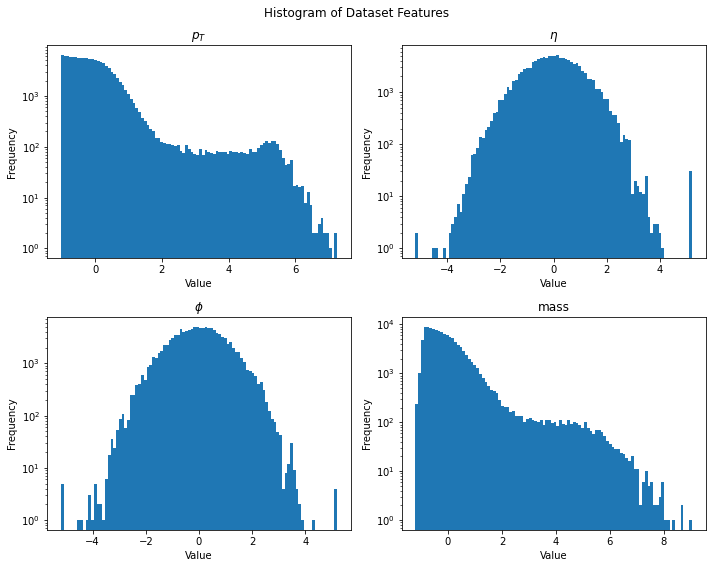

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Histogram of Dataset Features")
n_bins = 100

axs[0, 0].hist(xtr[:, 0], bins=n_bins,log=True)
axs[0, 0].set_title(labels_map[0])
axs[0, 0].set_xlabel("Value")
axs[0, 0].set_ylabel("Frequency")

axs[0, 1].hist(xtr[:, 1], bins=n_bins,log=True)
axs[0, 1].set_title(labels_map[1])
axs[0, 1].set_xlabel("Value")
axs[0, 1].set_ylabel("Frequency")

axs[1, 0].hist(xtr[:, 2], bins=n_bins,log=True)
axs[1, 0].set_title(labels_map[2])
axs[1, 0].set_xlabel("Value")
axs[1, 0].set_ylabel("Frequency")

axs[1, 1].hist(xtr[:, 3], bins=n_bins,log=True)
axs[1, 1].set_title(labels_map[3])
axs[1, 1].set_xlabel("Value")
axs[1, 1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_distribution_transformed.pdf',dpi=190)


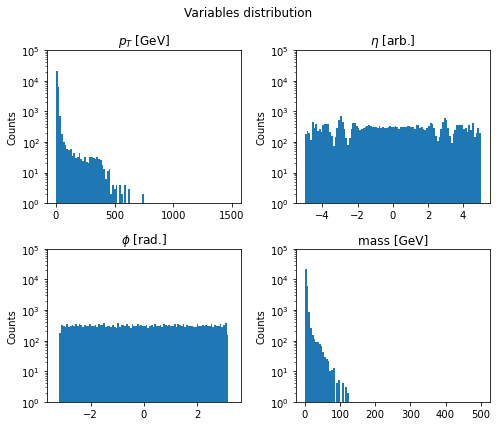

In [8]:
fig,axs = plt.subplots(2, 2,figsize=(7,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, range=(0,1500))
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, range=(0,500))
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution.pdf',dpi=190)

In [39]:
num_iterations = 8 #andrà messo a 8 su colab
num_features=4 #just for testing

base_dist = StandardNormal(shape=[num_features])

transforms = []
for _ in range(num_iterations):
  transforms.append(ReversePermutation(features=num_features))
  transforms.append(MaskedAffineAutoregressiveTransform(features=num_features,hidden_features=64))

transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
tp = sum(p.numel() for p in flow.parameters() if p.requires_grad)
print(tp)
optimizer = optim.Adam(flow.parameters())

flow = flow.to('cuda')

139840


50 tensor(3.7628, device='cuda:0', grad_fn=<NegBackward0>)
100 tensor(3.5409, device='cuda:0', grad_fn=<NegBackward0>)
150 tensor(3.4828, device='cuda:0', grad_fn=<NegBackward0>)
200 tensor(3.4460, device='cuda:0', grad_fn=<NegBackward0>)


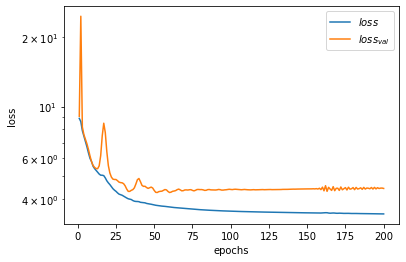

In [41]:
num_iter = 200 #andrà messo a 10000 su colab

figloss=plt.figure()
loss_values = []
loss_validation = []
for i in range(num_iter):
  optimizer.zero_grad()
  loss = -flow.log_prob(inputs=xt).mean()
  loss_val = -flow.log_prob(inputs=xval).mean()
  loss.backward()
  optimizer.step()
  loss_values.append(loss.cpu().detach().numpy())
  loss_validation.append(loss_val.cpu().detach().numpy())
  if (i+1) % 50 == 0:
    print(i+1,loss)

plt.plot(range(1, num_iter+1), loss_values, label='$loss$')
plt.plot(range(1, num_iter+1), loss_validation,label='$loss_{val}$')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()
figloss.savefig('figures/Loss_comparison.pdf',dpi=190)

In [42]:
sample = flow.sample(int(len(x)))
print(sample.shape)
sample = sample.cpu().detach().numpy()

sample[:,0:3] = quantile.inverse_transform(sample[:,0:3])
sample = scaler.inverse_transform(sample)
sample[:,0] = np.exp(sample[:,0]) - 10
sample[:,3] = np.exp(sample[:,3]) - 10
#function(data,range_log, range_std, range_quantile,direction)

torch.Size([118206, 4])


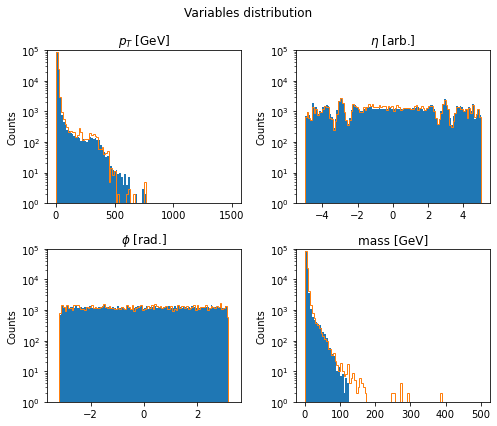

In [44]:
fig,axs = plt.subplots(2, 2,figsize=(7,6))
fig.suptitle("Variables distribution")
n_bins = 100

axs[0, 0].hist(x[:,0],bins=n_bins, range=(0,1500))
axs[0, 0].hist(sample[:,0],bins=n_bins, range=(0,1500),histtype='step')
axs[0, 0].set_title('Axis [0, 0]')
axs[0, 0].set_title('{} [GeV]'.format(labels_map[0]))
axs[0, 0].set_label("Counts")
axs[0, 0].set_ylim(1,10e4)

axs[0, 1].hist(x[:,1],bins=n_bins, range=(-5,5))
axs[0, 1].hist(sample[:,1],bins=n_bins, range=(-5,5),histtype='step')
axs[0, 1].set_title('{} [arb.]'.format(labels_map[1]))
axs[0, 1].set_ylim(1,10e4)

axs[1, 0].hist(x[:,2],bins=n_bins, range=(-3.30,3.30))
axs[1, 0].hist(sample[:,2],bins=n_bins, range=(-3.30,3.30),histtype='step')
axs[1, 0].set_title('{} [rad.]'.format(labels_map[2]))
axs[1,0].sharey(axs[0,1])

axs[1, 1].hist(x[:,3],bins=n_bins, range=(0,500))
axs[1, 1].hist(sample[:,3],bins=n_bins, range=(0,500),histtype='step')
axs[1, 1].set_title('{} [GeV]'.format(labels_map[3]))
axs[1,1].sharey(axs[0,0])

for ax in axs.flat:
    ax.set(ylabel='Counts',yscale='log')

fig.tight_layout()

plt.show()
fig.savefig('figures/Variables_distribution_with_reconstruction.pdf',dpi=190)

In [16]:
#training
# gaus = flow(data)
# unif = erf(gaus)
# unif' = unif * 2**N
# unif'' = int(unif')
# comp = unif''/2**N
# gaus' = erfinv(comp)
# data' = flow^-1(gaus') ==? data

In [30]:
###COMPRESSING###
N = 10

x_tensor = torch.tensor(x).to('cuda').float()
gaus = flow.transform_to_noise(x_tensor)

unif = torch.erf(gaus)
unif = unif * 2**N
unif = torch.floor(unif)

'''plt.figure()
plt.hist(unif.cpu().detach().numpy(), bins=100, label='Uniform Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Uniform Distribution')
plt.legend()
plt.show()
plt.savefig('figures/unif.pdf', dpi=190)'''


comp = unif/2**N   #compression
gaus_comp = torch.erfinv(comp)
def transform_to_data(flow,inputs):
    noise, _ = flow.self._transform.inverse(inputs)
    return noise

x_comp = flow.transform_to_data(gaus_comp)


x_comp = x_comp.cpu().detach().numpy()
x_comp = scaler.inverse_transform(x_comp)
x_comp = np.exp(x_comp) - 10



AttributeError: 'Flow' object has no attribute 'transform_to_data'

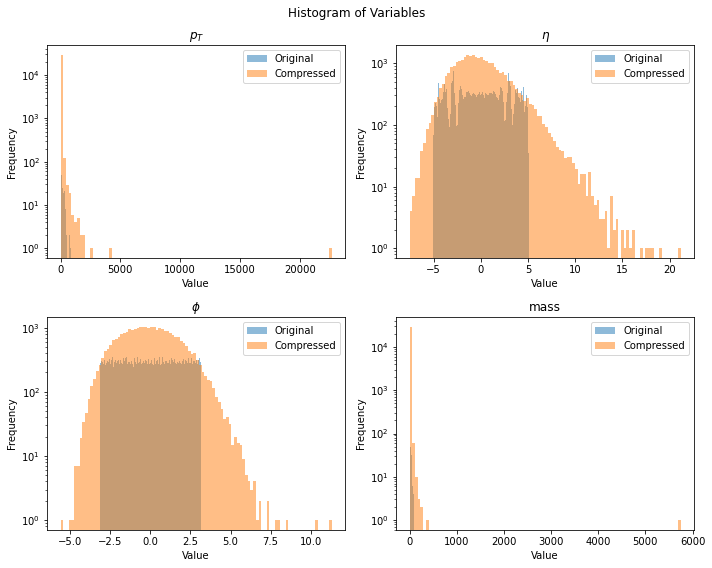

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("Histogram of Variables")

n_bins = 100

axs[0, 0].hist(x[:, 0], bins=n_bins, label='Original', alpha=0.5, log=True)
axs[0, 0].hist(x_comp[:, 0], bins=n_bins, label='Compressed', alpha=0.5)
axs[0, 0].set_title(labels_map[0])
axs[0, 0].set_xlabel("Value")
axs[0, 0].set_ylabel("Frequency")
axs[0, 0].legend()

axs[0, 1].hist(x[:, 1], bins=n_bins, label='Original', alpha=0.5, log=True)
axs[0, 1].hist(x_comp[:, 1], bins=n_bins, label='Compressed', alpha=0.5)
axs[0, 1].set_title(labels_map[1])
axs[0, 1].set_xlabel("Value")
axs[0, 1].set_ylabel("Frequency")
axs[0, 1].legend()

axs[1, 0].hist(x[:, 2], bins=n_bins, label='Original', alpha=0.5, log=True)
axs[1, 0].hist(x_comp[:, 2], bins=n_bins, label='Compressed', alpha=0.5)
axs[1, 0].set_title(labels_map[2])
axs[1, 0].set_xlabel("Value")
axs[1, 0].set_ylabel("Frequency")
axs[1, 0].legend()

axs[1, 1].hist(x[:, 3], bins=n_bins, label='Original', alpha=0.5, log=True)
axs[1, 1].hist(x_comp[:, 3], bins=n_bins, label='Compressed', alpha=0.5)
axs[1, 1].set_title(labels_map[3])
axs[1, 1].set_xlabel("Value")
axs[1, 1].set_ylabel("Frequency")
axs[1, 1].legend()

plt.tight_layout()
plt.show()
fig.savefig('figures/Variables_comparison.pdf', dpi=190)
